<center><h1>Investment returns, portfolios, and indexes</h1></center>

<center>William Mann</center>

<center>
<img src="https://wgjm1986.github.io/Investments/Emory_small.png" height="200px" width="300px" />
</center>

# Code behind all figures in the slides.
(The slides themselves appear below.)

In [1]:
# Import packages
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import os
import wrds
import fredapi
import math
import statsmodels.formula.api
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [16.0, 8.0]
from statistics import median
from scipy.stats import skew

In [2]:
# Download data
conn = wrds.Connection(wrds_username='wmann')

Loading library list...
Done


In [3]:
# Download daily returns on S&P 500 stocks during 1980-2023
sp500_daily = conn.raw_sql("""
    select a.*, b.date, b.ret
    from crsp.msp500list as a
    join (
        select permno, date, ret
        from crsp.dsf
        where date >= '01/01/1980' and date <= '12/31/2023'
    ) as b
    on a.permno = b.permno
    where b.date >= a.start and b.date <= a.ending
    order by b.date;
    """, date_cols=['start', 'ending', 'date'])

In [4]:
# Download monthly returns on S&P 500 stocks during 1980-2023
sp500_monthly = conn.raw_sql("""
    select a.*, b.date, b.ret
    from crsp.msp500list as a
    join crsp.msf as b on a.permno = b.permno
    where b.date >= a.start and b.date <= a.ending
    and b.date >= '01/01/1980' and b.date <= '12/31/2023'
    order by b.date;
    """, date_cols=['start', 'ending', 'date'])

In [5]:
# Download data on S&P 500 index returns
SP500 = conn.raw_sql("select caldt, spindx, vwretd, vwretx, ewretd, ewretx from crsp_a_indexes.msp500")
SP500['month'] = pd.to_datetime(SP500['caldt']).dt.to_period('M')
SP500 = SP500.drop(columns=['caldt']).set_index(['month'])
SP500 = SP500['1980':'2023']

In [6]:
conn.close()

In [7]:
%%capture
# Build figures of S&P 500 index and S&P 500 total return index
SP500_cumulative_return = (1+SP500.vwretd).cumprod();
Market_return_figure,ax = plt.subplots();
SP500_cumulative_return.plot(ax=ax);
ax.set_ylabel("Growth of $1 in a value-weighted portfolio \n of all S&P 500 stocks (reinvesting dividends)")

comparison_figure,ax = plt.subplots()
(1+SP500.vwretx).cumprod().plot(label="Increase in S&P 500 index",legend=True,ax=ax)
(1+SP500.vwretd).cumprod().plot(label="Increase in S&P 500 total return index",legend=True,ax=ax)

## Motivation

What's a "typical" stock return?

<center>
<img src="https://wgjm1986.github.io/Investments/Module%201/Week%201%20-%20Investment%20returns%2C%20portfolios%2C%20indexes/bessembinder_2a_close.png" width="1000px" />
</center>

## More motivation: Returns on S&P 500 stocks

Let's revisit Bessembinder's point with a slightly different dataset:  

The S&P 500 is a list of companies maintained by Standard and Poors, and roughly corresponds to the 500 largest companies by market capitalization.  
It captures the vast majority of the market without tracking of thousands of stocks.

Here we look at daily returns, since 1980, on the stocks in the S&P 500 at any moment.  
We again see that the average return is high, but the median return is zero.  

Why do we care? Because it is very hard to learn much about such heavily skewed data.

In [8]:
print("Mean daily return on S&P 500 stocks: "
      f"{ 100*sp500_daily['ret'].mean() :.2f}%")
print(f"  (Annualized: { 250*100*sp500_daily['ret'].mean() :.2f}%)")
print("Median daily return on S&P 500 stocks: "
      f"{ 100*sp500_daily['ret'].median() :.2f}%")
print(f"  (Annualized: { 250*100*sp500_daily['ret'].median() :.2f}%)")

Mean daily return on S&P 500 stocks: 0.06%
  (Annualized: 14.55%)
Median daily return on S&P 500 stocks: 0.00%
  (Annualized: 0.00%)


## Average returns across S&P 500 stocks

However, most investors own many stocks and thus get an average return.  
And average returns show less of the extreme skewness that we saw earlier:

In [9]:
sp500EW_daily = sp500_daily.groupby('date')['ret'].mean()
print("Mean of average daily return: "
      f"{100*sp500EW_daily.mean() :.2f}%")
print(f"  (Annualized: {250*100*sp500EW_daily.mean() :.2f}%)")
print("Median of average daily return: "
      f"{100*sp500EW_daily.median() :.2f}%")
print(f"  (Annualized: {250*100*sp500EW_daily.median() :.2f}%)")

Mean of average daily return: 0.06%
  (Annualized: 14.55%)
Median of average daily return: 0.08%
  (Annualized: 20.95%)


In [10]:
sp500EW_monthly = sp500_monthly.groupby('date')['ret'].mean()
print("Mean of average monthly return: "
      f"{100*sp500EW_monthly.mean() :.2f}%")
print(f"  (Annualized: {12*100*sp500EW_monthly.mean() :.2f}%")
print("Median of average monthly return: "
      f"{100*sp500EW_monthly.median() :.2f}%")
print(f"  (Annualized: {12*100*sp500EW_monthly.median() :.2f}%")

Mean of average monthly return: 1.18%
  (Annualized: 14.15%
Median of average monthly return: 1.36%
  (Annualized: 16.37%


## Takeaways

Individual stock returns, at high frequencies, are likely to be a very difficult thing to study, forecast, or model, because they are incredibly skewed in the data. 

This actually makes a lot of sense, as we will discuss in a few weeks.

But when we look at what actually matters to most investors -- an average of many stock returns, measured at a lower time frequency -- there is a bit more order.

So we will be paying a lot of attention to average returns.  

But the next question is, exactly what kind of average?

We will focus most attention on a *value-weighted* average of the individual returns.  

The next section explains why.

## Studying portfolios of investments

The goal of this class is to get some perspective on questions like the following:
- How do investors allocate their funds? What tools exist to help with this?
- What kind of return they get? How could they do better?

So we will take a top-down perspective.  
We will not spend a lot of time looking at individual stocks, bonds, etc. 

Instead we will mostly think about general strategies within asset classes, how those strategies lead investors to hold certain portfolios, and how the portfolio generates an overall return that is an *average* of the returns of the individual securities.

## Specific strategies and their portfolios

This week, we will focus on three strategies an investor could use to build a portfolio:  
- Price weighting: Assets are weighted by their market price.
- Equal weighting: Assets all receive equal weight in the portfolio.
- Value weighting: Assets are weighted by total supply. (For stocks, by market cap.)

In each case, using some example data, we will ask:

- How to form a portfolio reflecting that strategy?
- How to compute the return on that portfolio?
- How to rebalance the portfolio to stay in line with the strategy?
- What is the connection with the return on an index?

All the ideas apply to any asset class, but it is probably easiest to think about stocks.

## Takeaways

We will see that the answers to the previous questions depend on:

- The price change of each security in the portfolio,
- The payout of each security (dividends, coupons, etc),
- Changes in the total supply of each investment (for example, stock splits, stock dividends, repurchases).

Most importantly, we will see why value-weighting is always the natural benchmark.

Homework 1 builds on these examples.

## Building and rebalancing a portfolio

A portfolio is just a collection of securities. To build one:

- Decide on the list of securities you want to include.
- Choose a strategy for how much to allocate to each one.
- Calculate the amounts you need to buy at current market prices.

After building a portfolio, you might also want to rebalance regularly, in order to stay in line with the strategy you chose above:

- Recalculate the portfolio that now aligns with your strategy, based on the new prices of each security and any other events that have happened.
- Buy or sell enough of each individual security to arrive at this desired portfolio.

## Measuring portfolio returns

The return on a portfolio between two dates can be calculated as:

- The ending value of securities owned and dividends received, divided by the initial value of the securities, minus 1;

- or, the weighted average return of each individual security, being sure to include the dividends that they paid, where the weights are the portfolio’s initial dollar allocations.

Either method will give the same answer.

### Keeping track of trading activity during rebalancing

Different strategies require different amounts of trading to rebalance.  
It is important to track this activity because trading is costly.

**Turnover** during any time is gross trading activity, as a percent of starting portfolio size. 

(To be clear, the exact trading costs are still only a fraction of this amount, and depend greatly on who is doing the trading.)

**Gross trading activity** is total purchases *plus* total sales. 

(We add them together because both are costly.)

For comparison, **net trading activity** is purchases *minus* sales. 

(This does not measure trading costs, but is still useful: It must equal the amount added or withdrawn from the portfolio, plus reinvestment of dividends or coupons.)

## Example 1: Textbook table 2.2, page 46

| Stock | Initial price | Final price | Shares (m) | Initial market cap (\$m) | Final market cap (\$m) |
|-------|---------------|-------------|------------|--------------------------|------------------------|
| ABC   | \$25          | \$30        | 20         | \$500                    | \$600                  |
| XYZ   | \$100         | \$90        | 1          | \$100                    | \$90                   |

## Example 2: Data on AMGN and GILD from 2017

| Stock | Initial price | Final price | Initial shares (m) | Final shares (m) | Dividends paid per share, \$ |
|-------|---------------|-------------|--------------------|------------------|------------------------------|
| AMGN  | \$146.21      | \$173.90    | 738.2              | 722.2            | \$4.60                       |
| GILD  | \$71.61       | \$71.64     | 1310               | 1308             | \$2.08                       |

## Importance of the value-weighted portfolio

Earlier on, we looked at simple average returns across stocks.  
As we have now seen, these averages match the return on an *equal-weighted* portfolio. 

But most investors in fact hold a *value-weighted* portfolio. This portfolio represents the "market return" and a "passive strategy", and is the benchmark for everything else.

This may seem surprising, but the value-weighted portfolio has many special features:
- It represents a proportional slice of the overall market. This means it is the only strategy that *everyone* can hold, and also that it requires the least rebalancing.
- It is *guaranteed* to match the overall market return. Any performance you gain or lose with a different portfolio is offset by the rest of the market.
- Although it weights *companies* very unevenly, it diversifies equally across dollars of expected future *profits*.

## Performance of the value-weighted S&P 500 portfolio since 1980

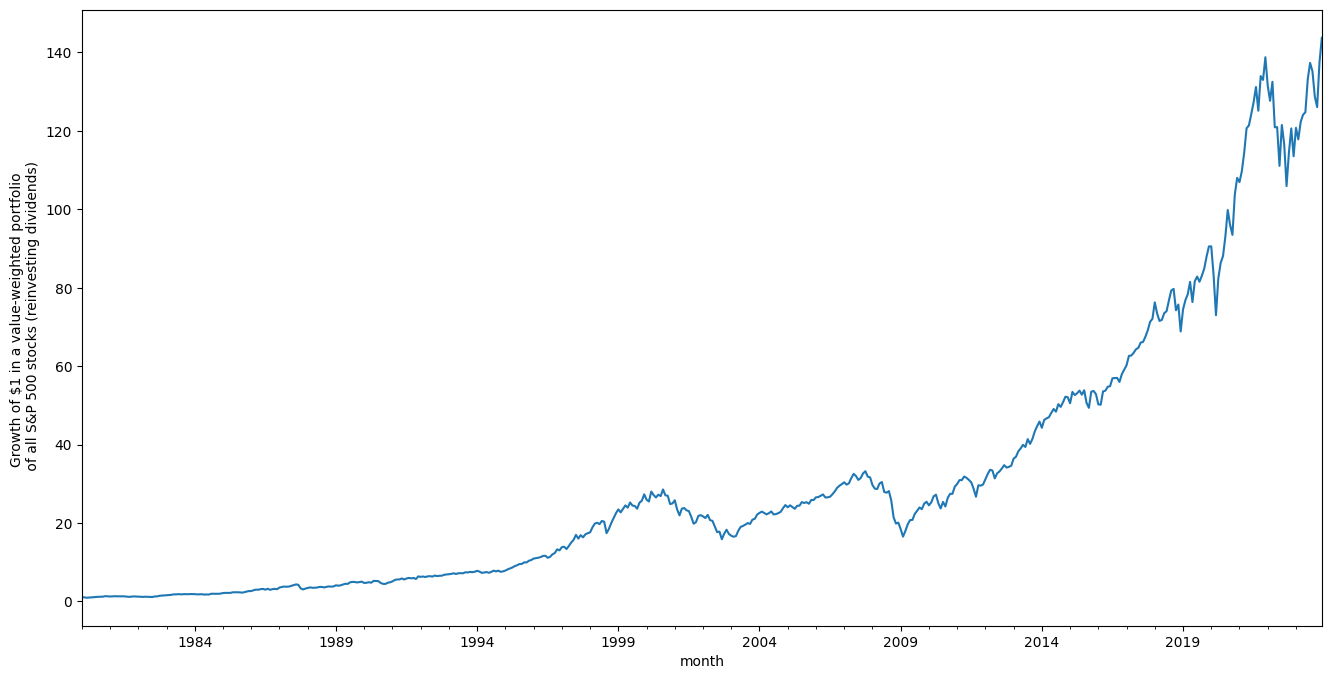

In [11]:
Market_return_figure

## Indexes of investment performance

An index helps track the performance of a given strategy/portfolio.

Examples:

- **DJIA**: price-weighted portfolio of stocks.
- **S\&P 500 index**: value-weighted portfolio of stocks.
- **Bloomberg Agg** (fka Barclay’s Agg): value-weighted, bonds.

Each index features a list of investments, and a weighting scheme.

The level of the index by itself is a meaningless, arbitrary number.

Index *changes* are connected to returns on the underlying strategy.
But the exact connection depends on how the index is constructed.

## S&P 500 index calculation

Most US stock indexes are designed to measure returns to their
underlying strategy from capital gains alone, *excluding dividends.*

For example, the S&P 500 index is calculated with this formula:

$$
\text{S&P 500 index level} = \frac{ \sum P \times Q }{ \text{Divisor} }
$$

The divisor is adjusted in response to events that change market cap
without triggering a capital gain for the individual investor, such as
share issuance or repurchase. (We will do an example of this.)

So the index return *does not* include the return from dividends.
There is an S&P 500 “total return” index, but it is not as well-known.

It doesn’t have to be this way! The main German stock index, the DAX, is a total return index.

## S&P 500 index vs total return index

Dividends are important, especially over long horizons!

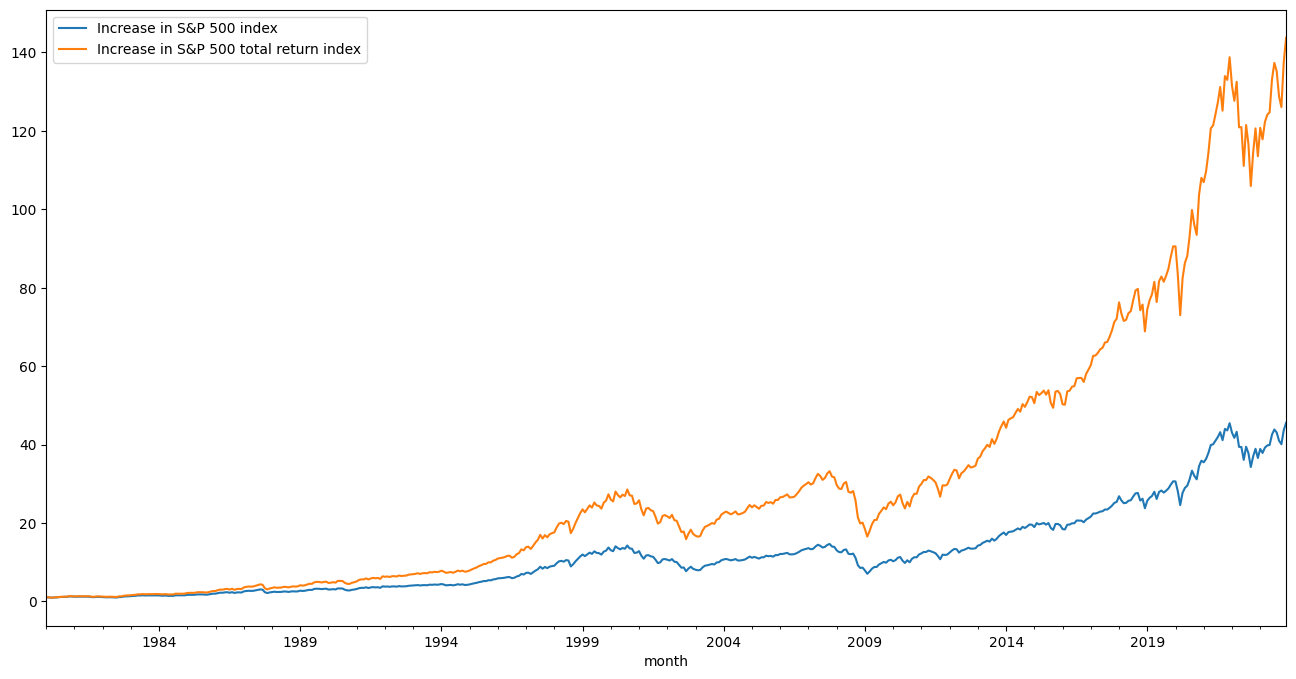

In [12]:
comparison_figure

## Bloomberg/Barclays aggregate bond index

- The best-known US bond market index. The formal name has
changed several times. It is generally just called the “Agg.”

- It reflects a value-weighted portfolio of a broad range of
fixed-income securities. Like most bond indexes, it is a “total
return” index, meaning it does include coupon reinvestment.

- But unlike stocks, it is not obvious which securities to include.
Currently it’s mostly Treasuries, MBS, and IG corporate.
But this is always a source of debate and controversy.
For example, some argue for adding munis and junk bonds.

- It’s also not obvious if the portfolio represented by this strategy
is really the correct benchmark for investors to use.

- Many basic questions remain open about portfolio management
and performance assessment with fixed income.

<center>
<img src="https://wgjm1986.github.io/Investments/Module%201/Week%201%20-%20Investment%20returns%2C%20portfolios%2C%20indexes/agg_components_small.png" width="1200px" />
</center>

## Agg index historical performance
[source](https://advisors.vanguard.com/insights/article/unpack-the-challenges-of-rising-bond-fund-yields)

![MyImage](https://github.com/wgjm1986/Investments/blob/main/Module%201/Week%201%20-%20Investment%20returns,%20portfolios,%20indexes/agg_performance.png?raw=True)